# CC3084 – Data Science — **Laboratorio 5: RNN (LSTM) para Series de Tiempo**

**Serie:** *Industrial Production: Ice cream and frozen dessert (IPN31152N)*  
**Fuente:** FRED (Federal Reserve Bank of St. Louis) — https://fred.stlouisfed.org/series/IPN31152N

**Integrantes**
- Sofia Velasquez, 22049
- Jose Marchena, 22398

<a hhref="https://github.com/Sofiamishel2003/RNN_para_Series_de_Tiempo">**Repositorio**</a>

## 0) Preparación del entorno


In [1]:
%pip install -q pandas numpy matplotlib pandas_datareader

Note: you may need to restart the kernel to use updated packages.


## 1) Carga y exploración de datos

La serie **IPN31152N** está en FRED. Intentaremos descargarla con `pandas_datareader`.  


            produccion
DATE                  
2000-01-01     93.6497
2000-02-01    111.6591
2000-03-01    125.4885
2000-04-01    136.9998
2000-05-01    136.0725
       produccion
count  306.000000
mean   118.699614
std     24.802970
min     68.060900
25%    102.267825
50%    116.391150
75%    132.100425
max    196.817400


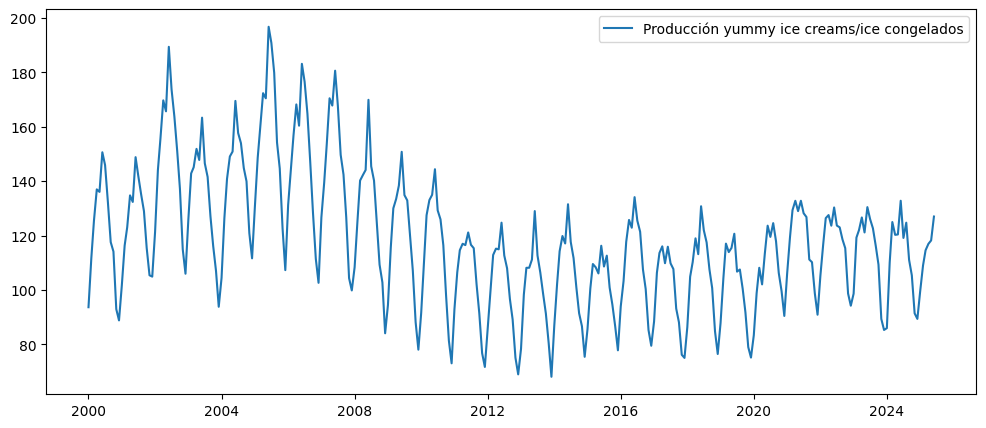

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# Descargar datos de FRED
series = web.DataReader("IPN31152N", "fred", start, end)

series.rename(columns={"IPN31152N": "produccion"}, inplace=True) # Renombrar columna

# Visualizar primeros datos
print(series.head())
print(series.describe())
plt.figure(figsize=(12,5))
plt.plot(series, label="Producción yummy ice creams/ice congelados")
plt.legend()
plt.show()

## 2) División de conjuntos

Usaremos los **últimos 24 meses** como conjunto de prueba. El resto será entrenamiento.


Entrenamiento: (282, 1)
Prueba: (24, 1)


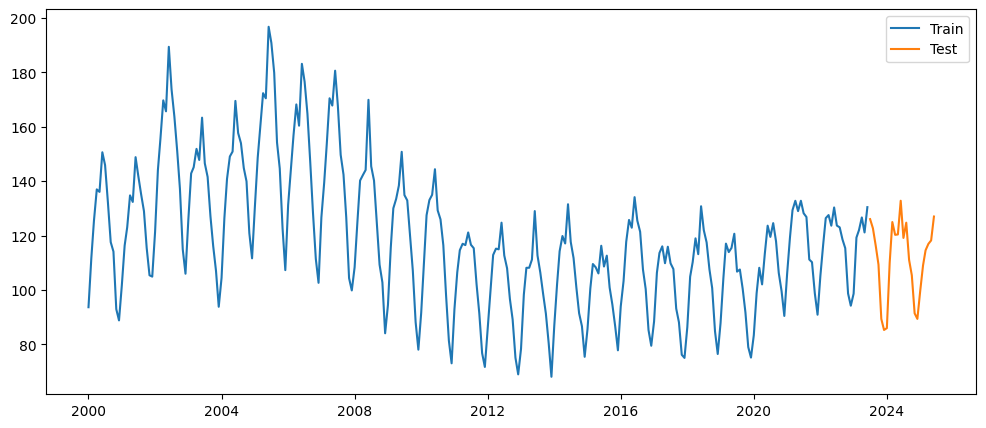

In [3]:
# Definir tamaño de prueba (24 meses)
train = series.iloc[:-24]
test = series.iloc[-24:]

print("Entrenamiento:", train.shape)
print("Prueba:", test.shape)

plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.legend()
plt.show()

## 3) Normalización y preparación

Aplicamos `MinMaxScaler` . Luego construimos un `TimeSeriesGenerator`.
- `batch_size` tamaño del lote de entrenamiento.


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
datos_entreno_escalados = scaler.transform(train)
datos_prueba_escalados = scaler.transform(test)

La longitud se basa en que estos datos son anuales por lo que se debe escoger un número de meses igual o aproximado a el número de meses en el año. Con series de tiempo, una buena práctica es seleccionar tandas de una secuencia


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
longitud = 12
batch_size = 1
train_gen = TimeseriesGenerator(datos_entreno_escalados, 
                                datos_entreno_escalados,
                                length = longitud, 
                                batch_size = batch_size)
X,y = train_gen[0]
print(f'Dado el arreglo: \n{X.flatten()}')
print(f'Predecir esta y: \n {y}')

Dado el arreglo: 
[0.19873793 0.3386097  0.44601709 0.53542074 0.52821877 0.64139286
 0.60487199 0.49884006 0.38464388 0.35774427 0.19325704 0.16112274]
Predecir esta y: 
 [[0.26127458]]


In [83]:
val_gen = TimeseriesGenerator(datos_prueba_escalados,
                              datos_prueba_escalados, 
                              length = longitud, 
                              batch_size = batch_size)

## 4) Construccion del Modelo

Se decidio por una topologia de dos capas LSTM
La primera incurre en 32 perceptrones, y la segunda en 16.
Como tecnica de regularizacion, se aplicao L2 para pesos recurrentes y pesos iniciales con un valor lambda de 1e-4 para ambas capas.
Se decidio por no utilizar dropout debido a que empeoraba el rendimiento. Por ultimo, se aplica una capa densa para poder realizar predicciones individuales

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import regularizers

epochs = 10
# Define
lstm_model = Sequential([
    LSTM(
        32, 
        return_sequences=True,
        input_shape=(longitud,1),
        kernel_regularizer=regularizers.l2(0.0001),      # L2 on input weights
        recurrent_regularizer=regularizers.l2(0.0001),
    ),
    LSTM(
        16, 
        kernel_regularizer=regularizers.l2(1e-4),      # L2 on input weights
        recurrent_regularizer=regularizers.l2(1e-4),
    ),
    Dense(1) # Output
])


C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 5) Entrenamiento y evaluación: 
Se optio por utilizar 10 epocas debido a lo simle de la informacion. Asimismo, debido a la naturaleza de regresion de las predicciones, se opto por usar la perdida de MSE.

Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0390
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0332
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0253
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0177
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0116
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105
Epoch 9/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100
Epoch 10/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097


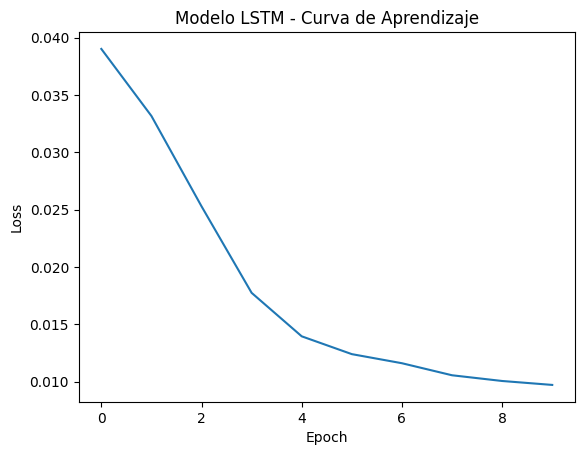

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(
    train_gen, 
    epochs=epochs,
    verbose=1
)
plt.title("Modelo LSTM - Curva de Aprendizaje")
plt.plot(np.arange(0,epochs),history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

En la curva de aprendizaje anterior, se puede observar un decesno apropiado, sin sintomas de over-underfitting y un error minimo MSE de 0.01 para los datos estandarizados, lo cual se considera aceptable. En evaluaciones anteriores sin regularizacion, se observaron patrones menos predecibles en la curva, por lo que su alizamiento se puede atribuir a estos.<br>
Asimismo, a continuacion se muestra la prediccion graficada con los demas datos de la serie de tiempo, en donde podemos observar un comportamiento de alizamiento del ruido, y una captura apropiada de las tendencias generales

C:\Users\JM\AppData\Local\Temp\ipykernel_12216\1843420059.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start=train.iloc[0].name, periods=len(train), freq="M"),
C:\Users\JM\AppData\Local\Temp\ipykernel_12216\1843420059.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start=test.iloc[0].name, periods=len(test), freq="M"),
C:\Users\JM\AppData\Local\Temp\ipykernel_12216\1843420059.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start=test.iloc[0].name, periods=len(y_pred), freq="M"),


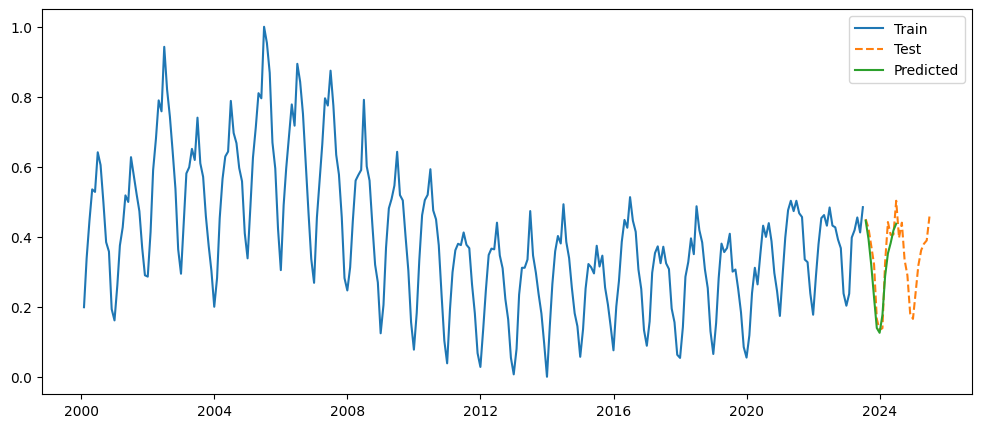

In [100]:

y_pred = lstm_model.predict(val_gen, verbose=0)

plt.figure(figsize=(12,5))
plt.plot(
    pd.date_range(start=train.iloc[0].name, periods=len(train), freq="M"),
    datos_entreno_escalados, 
    label="Train"
)
plt.plot(
    pd.date_range(start=test.iloc[0].name, periods=len(test), freq="M"),
    datos_prueba_escalados, 
    label="Test",
    linestyle='--'
)
plt.plot(
    pd.date_range(start=test.iloc[0].name, periods=len(y_pred), freq="M"),
    y_pred,
    label="Predicted"
)
plt.legend()
plt.show()

## 6) Análisis y discusión: 
- Interpreten resultados y discutan limitaciones/mejorasposibles.


El uso de redes neuronales recurrentes puede conllevar la manifestacion del efecto de gradiente de fuga, sin embargo, variaciones como el Long-Short Memory evita este proceso al proveer acceso a informacion previa y actual el calculo de una prediccion. En la evaluacion de estos datos se pudo observar que con regularizacion apropiada nuestro modelo LSTM logro reducir su error a un nivel aceptable y realizar predicciones precisas para un periodo de 12 meses. Logra capturar estacionalidad y tendenci de nuestro conjunto de datos y al mismo tiempo alizar el ruido.<br>
Como mejoras posibles, se recomienda una evaluacion mas exhaustiva para el tamaño de las LSTM pues no se evaluo muy profundamente en este laboratorio. Asimismo, debido a la longitud de 12 meses para la generacion de las series de tiempo, la prediccion se ve limitda a este factor. Se podria realizar un modelo que prediga directamente para un periodo mas grande cambiando su topologia.
Como conclusion.

